## Using ART to Defend against Poisoning Attacks using DP-InstaHide

DP-InstaHide is a training method developed by [Borgnia et. al. (2021)](https://arxiv.org/abs/2103.02079). This method provides a differential privacy guarantee and strong empirical performance against poisoning attacks. The training protocol uses:
* Data augmentation (such as Mixup)
* Additive noise (such as Laplacian noise)

Using this method, we show how ART can defend against poisoned samples.

In [2]:
import os
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# set module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ignore warnings
warnings.filterwarnings('ignore')

# disable TensorFlow eager execution
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.preprocessor import Mixup
from art.defences.trainer import DPInstaHideTrainer
from art.estimators.classification import KerasClassifier
from art.utils import load_mnist, preprocess

In [3]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

### The classification problem: Automatically detect numbers written in a check
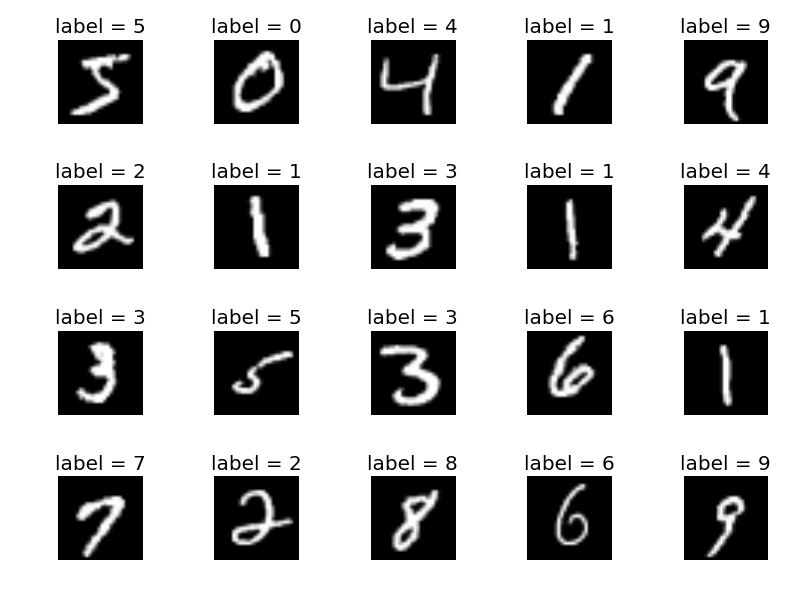

In [4]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

print('x_raw:', x_raw.dtype, x_raw.shape)
print('y_raw:', y_raw.dtype, y_raw.shape)
print('x_raw_test:', x_raw_test.dtype, x_raw_test.shape)
print('y_raw_test:', y_raw_test.dtype, y_raw_test.shape)

x_raw: uint8 (7500, 28, 28)
y_raw: uint8 (7500,)
x_raw_test: uint8 (10000, 28, 28)
y_raw_test: uint8 (10000,)


### Adversary's goal: make some easy money 
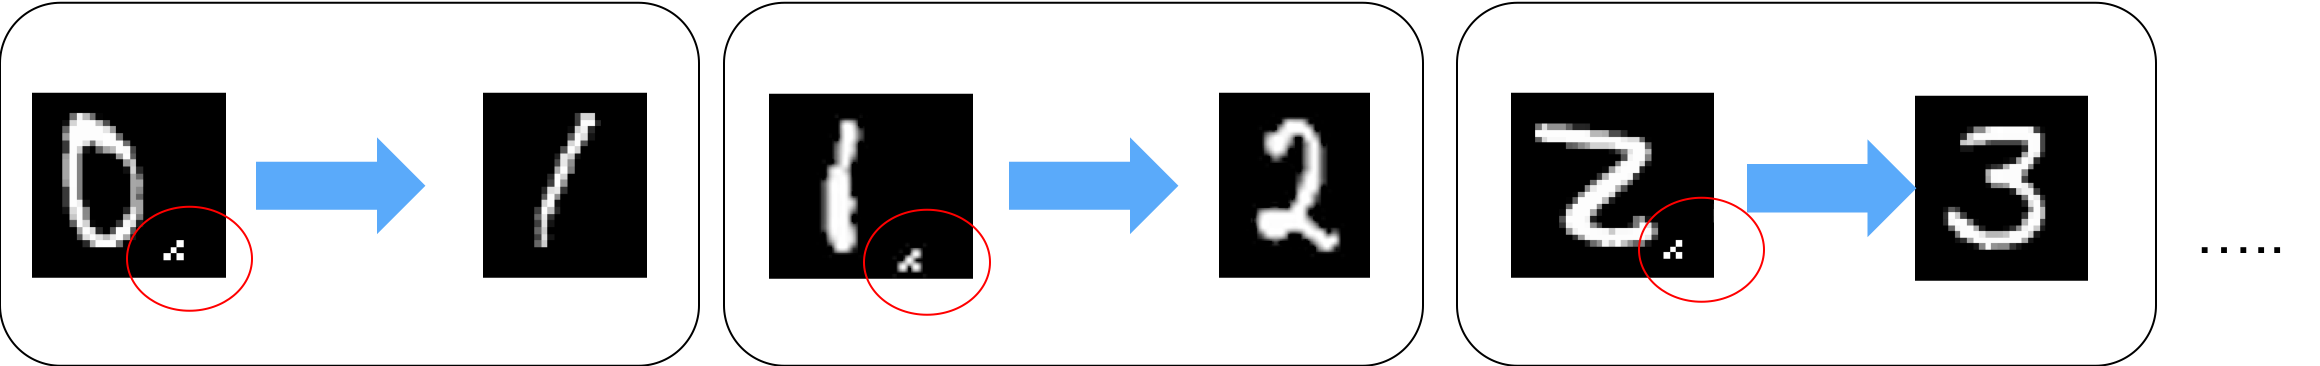

In [5]:
MAX_VAL = np.max(x_raw)
BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=MAX_VAL)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=MAX_VAL) 
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")

def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources = np.arange(10) # 0, 1, 2, 3, ...
    targets = (np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [6]:
PERCENT_POISON = 0.33

# Poison training data
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, PERCENT_POISON, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, PERCENT_POISON, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

print(f'x_train:', x_train.dtype, x_train.shape)
print(f'y_train:', y_train.dtype, y_train.shape)
print('total poisoned train:', is_poison_train.sum())
print()
print(f'x_test: ', x_test.dtype, x_test.shape)
print(f'y_test: ', y_test.dtype, y_test.shape)
print('total poisoned test:', is_poison_test.sum())

x_train: float64 (11194, 28, 28, 1)
y_train: float32 (11194, 10)
total poisoned train: 3694

x_test:  float64 (14925, 28, 28, 1)
y_test:  float32 (14925, 10)
total poisoned test: 4925


## Victim bank trains a neural network

In [7]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [8]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

[INFO] Inferred 7 hidden layers on Keras classifier.


Train on 11194 samples


2023-12-04 14:36:57.653025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-04 14:36:57.698419: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_1/bias/v/Assign' id:479 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/v, training/Adam/dense_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/3
11194/11194 [==============================] - 3s 312us/sample - loss: 1.3151 - accuracy: 0.5208
Epoch 2/3
11194/11194 [==============================] - 3s 303us/sample - loss: 0.4644 - accuracy: 0.8624
Epoch 3/3
11194/11194 [==============================] - 3s 309us/sample - loss: 0.2869 - accuracy: 0.9166


## The victim bank evaluates the model

### Evaluation on clean test samples

2023-12-04 14:37:11.219603: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Softmax' id:121 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


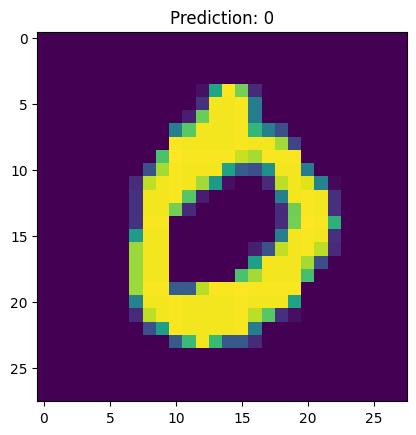

Clean test set accuracy: 96.79%


In [9]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.title(f"Prediction: {clean_preds[c_idx]}")
plt.show()

clean_acc = clean_correct / clean_total
print(f"Clean test set accuracy: {(clean_acc * 100):.2f}%")

### But the adversary has other plans...

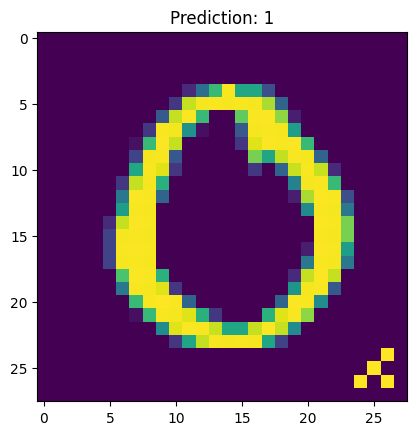

Effectiveness of poison: 94.48%


In [10]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.title(f"Prediction: {poison_preds[c_idx]}")
plt.show()

poison_acc = poison_correct / poison_total
print(f"Effectiveness of poison: {(poison_acc * 100):.2f}%")

### Evaluate accuracy on entire test set

In [11]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print(f"Overall test set accuracy (with effectiveness of poison): {(total_acc * 100):.2f}%")

Overall test set accuracy (with effectiveness of poison): 96.03%


## Defend Against Poison using DP-InstaHide

### Re-Initialize the model

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

classifier = KerasClassifier(model=model, clip_values=(0, 1))

[INFO] Inferred 7 hidden layers on Keras classifier.


### Re-train the model using DP-InstaHide

We will be using 2-way Mixup for the augmentation and Laplacian noise with a scale of 0.3 for the additive noise.

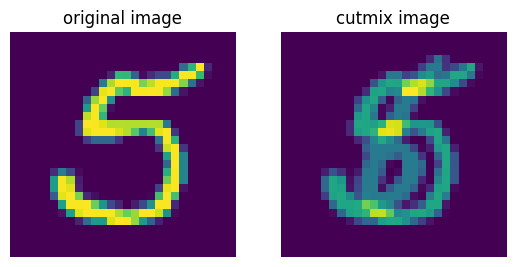

  y     y_aug
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [1.    0.594]
 [0.    0.406]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]]


In [29]:
mixup = Mixup(num_classes=10, num_mix=2)

x_aug, y_aug = mixup(x_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(x_train[0])
ax1.set_title(f'original image')
ax1.axis('off')

ax2.imshow(x_aug[0])
ax2.set_title(f'cutmix image')
ax2.axis('off')

plt.show()

print('  y     y_aug')
print((np.stack([y_train[0], y_aug[0].round(3)], axis=-1)))

In [21]:
trainer = DPInstaHideTrainer(
    classifier=classifier,
    augmentations=mixup,
    noise='laplacian',
    scale=0.3,
    clip_values=(0, 1)
)
trainer.fit(x_train, y_train, nb_epochs=3, batch_size=128)

[INFO] Performing adversarial training with DP-InstaHide protocol
[INFO] Adversarial Training DP-InstaHide


DP-InstaHide training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

2023-12-04 08:52:40.165741: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/conv2d_4/kernel/m/Assign' id:5474 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/conv2d_4/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/conv2d_4/kernel/m, training_4/Adam/conv2d_4/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-04 08:52:40.410579: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_5/Softmax' id:5203 op device:{requested: '', assigned: ''} def:{{{node dense_5/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the 

### Re-evaluation on clean test samples

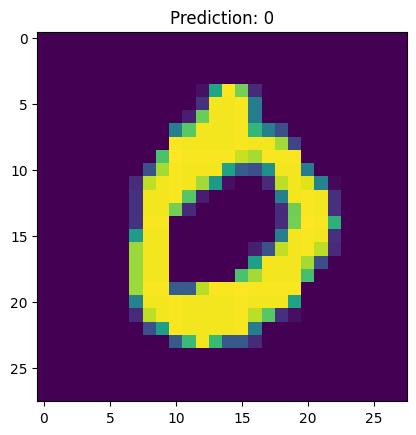

Clean test set accuracy: 93.21%


In [22]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.title(f"Prediction: {clean_preds[c_idx]}")
plt.show()

clean_acc = clean_correct / clean_total
print(f"Clean test set accuracy: {(clean_acc * 100):.2f}%")

### Re-evaluate on poisoned test samples

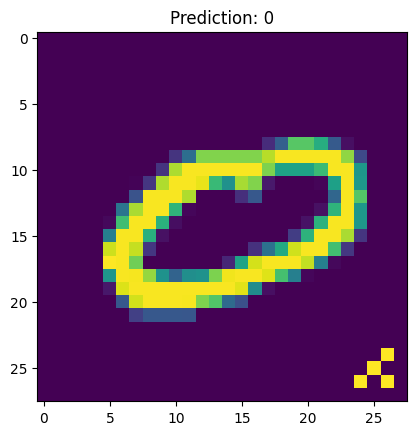

Effectiveness of poison: 5.54%


In [23]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.title(f"Prediction: {poison_preds[c_idx]}")
plt.show()

poison_acc = poison_correct / poison_total
print(f"Effectiveness of poison: {(poison_acc * 100):.2f}%")

### Re-evaluate accuracy on the entire test set

In [24]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print(f"Overall test set accuracy (with effectiveness of poison): {(total_acc * 100):.2f}%")

Overall test set accuracy (with effectiveness of poison): 64.28%
